<a href="https://colab.research.google.com/github/Cr1mson901/IntroToPyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Let's explore an example of end-to-end workflow

In [ ]:
import torch
from torch import nn #contains all the building blocks for pytorch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

what_we_are_covering = {1:'data(prepare and load)',
                        2:'build model',
                        3:'fitting the model to data',
                        4:'making predicitions',
                        5:'saving and loading a model',
                        6:'put it all together'}

torch.__version__

'2.1.0+cu121'

## 1.Data(preparing and loading)

Data can be almost anything
* Excel spreadsheet
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a number representation
2. Build a model to learn patterns in that number representation

To showcase this, let's create some *known* data using the linear regression formula

We'll use a linear regression formula to make a straight line with know parameters

In [ ]:
# Create *known# parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = .02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets
* Training set - always 60-80%
* Test set- Always 10-20%
* validation set

In [ ]:
# Create a train/test split
train_split = int(.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

In [ ]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  #Plots traing data, test data and compares predictions

  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  #Are ther predictions
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Prediction data')

  #show the legend, labels
  plt.legend(prop={'size':14})



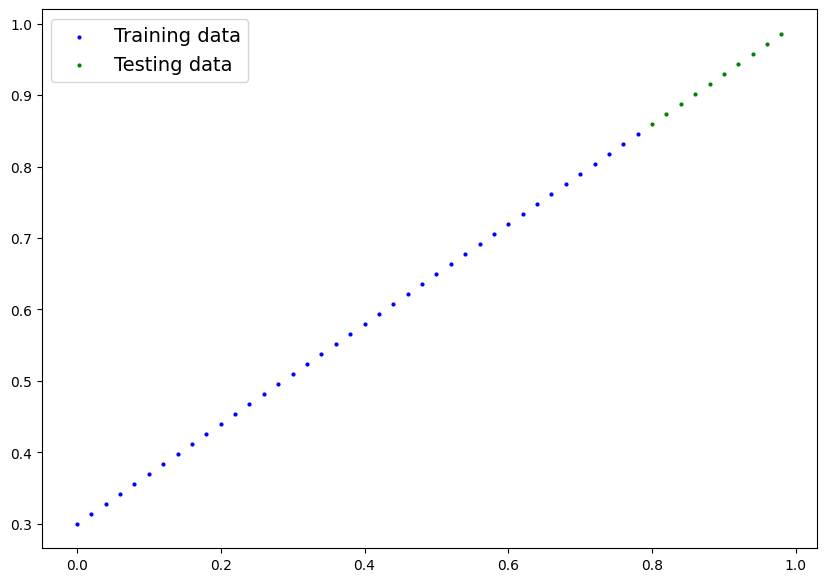

In [ ]:
plot_predictions()

## Create a model
Our first PyTorch model!

What our model does:
* Start with random values(weight & bias)
* Look at traing data and adjust the random values to better represent(or closer to) the ideal values (the weight and bias values we created)

How?

Through two main algorithms:
1. Gradient descent
2. Backpropogation

In [ ]:
#Create linear regression model class
class linearRegressionModel(nn.Module): #almost everything in pytorch inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,#True by default
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                             requires_grad=True,
                             dtype=torch.float))
  #Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:#returns torch.Tensor
    return self.weights * x + self.bias



### PyTorch model building essentials

* torch.nn contains all the building block for computational graphs
* Parameters - what parameters a model should learn
* torch.optim - this is where the optimizers in PyTorch live

### Checking the contents of our PyTorch model

Now let's see whats inside...

SO we can check out our model parametes using .parameters

In [ ]:
# Create a random Seed
torch.manual_seed(42)

#Create an instance of the model
model_0 = linearRegressionModel()

#Check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using 'torch.inference_mode()'

To check our model's predictive power, let's see how well it predicts 'y_test' based on 'X_test'

When we pass data through our model, it's going to run it through the forward method

In [ ]:
# Make predictions with model
with torch.inference_mode():#Context manager like reading files, makes code faster, gets rid of grad tracking
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

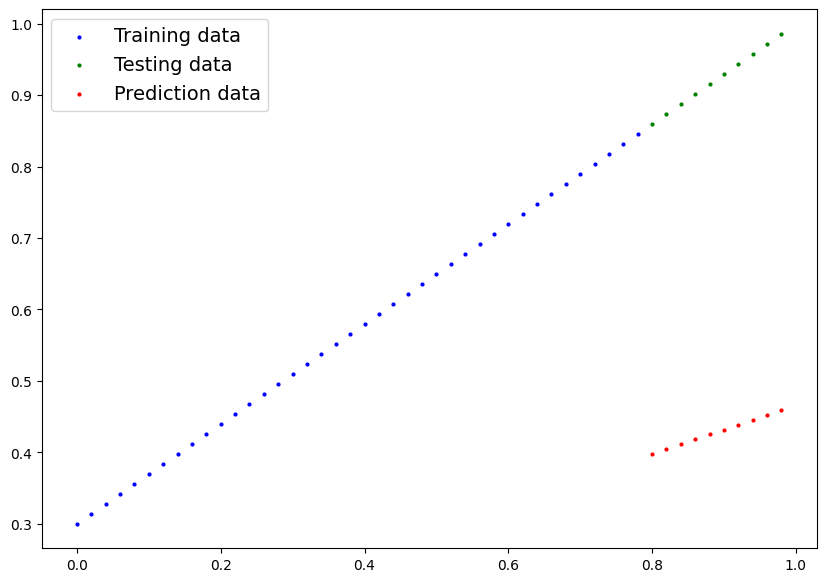

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move the parameters closer to our ideal function

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas

Things we need to train:

**Loss functions:** A function to measure how wrong your model's predictions are

**Optimizer:** Takes into account the loss function then makes the model better

* We need a training loop and a testing loop

In [ ]:
#Mean absolute error, Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),#model parameters
                            lr=0.01)#lr = learning rate, the bigger the more it adjusts the parameter



### Building a training loop(and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's forward functions)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss(**backpropagation**)
5. Optimizer step - use the optimizer (**gradient descent**)

In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data(hyperperameter)
epochs = 200
#Track different values to compare experiments
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train()#train mode in PyTorch sets all parameters that require gradients to gradients true

  #1. Forward pass
  y_pred = model_0(X_train)#runs the forward method

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5 Step the optimizer
  optimizer.step() # by default how the optimizer changes will accumalate throught the loop, so we have to zero it in step #3

### Testing
  model_0.eval()
  with torch.inference_mode():#turns off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch%10 == 0:
    epoch_count.append(epoch)
    test_loss_values.append(test_loss)
    loss_values.append(loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
  # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

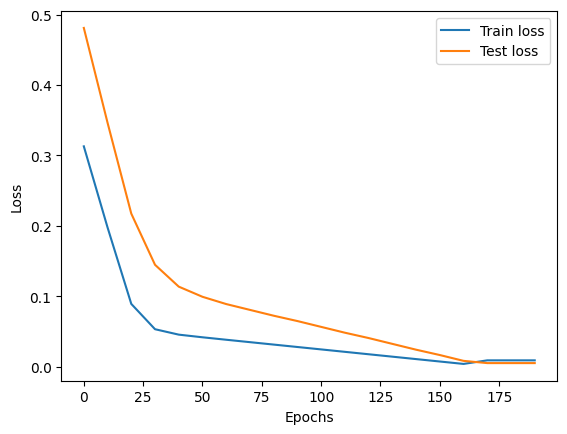

In [ ]:
#Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values)), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

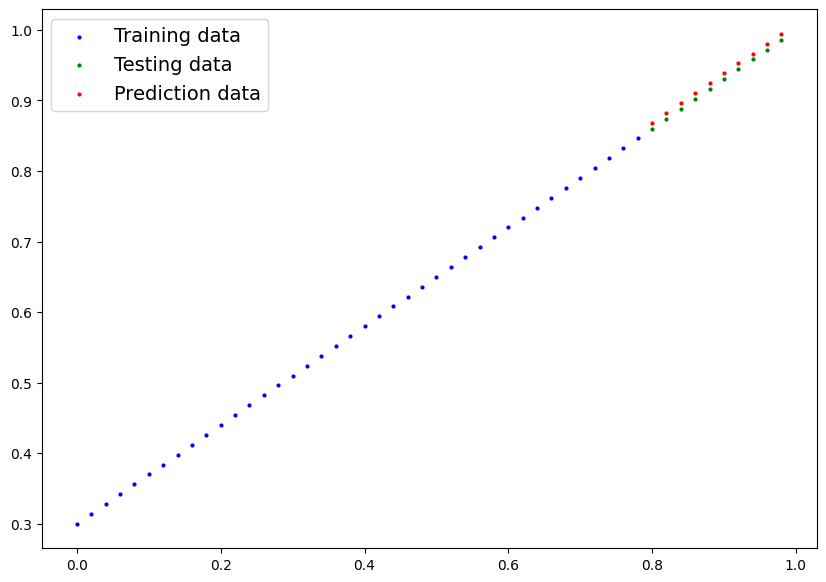

In [ ]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch

1. 'torch.save()' this saves a Pytorch object in pickle format
2. 'torch.load()' allows you to load
3. 'torch.nn.Module.load_state_dict() - load a models saved state dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving our PyTorch model
from pathlib import Path#pythons model for writing to paths

#1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'#pth or pt for pytorch files
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model.state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Loading pytorch model

#Since we saved a state_dict instead of the entire model, we'll create a new instance of our model
loaded_model_0 = linearRegressionModel()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_0.state_dict()

loaded_model_0.eval()#use when making predictions
with torch.inference_mode():
  preds_loaded = loaded_model_0(X_test)
preds_loaded


tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare model preds
y_preds_new == preds_loaded

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

### Excise, Recode all of the code above without assistance

In [ ]:
#Data and class set up
import torch
from torch import nn

#Device agnostic mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



weight = .63
bias = .48

start = 0
stop = 1
step = .01

data = torch.arange(start, stop, step).unsqueeze(dim=1)
X_train = data[:int((len(data) * .8))]
X_test = data[int(len(data) * .8):]

y_train = X_train * weight + bias
y_test = X_test * weight + bias

class linearRegressionModel_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))#Don't forget nn.Parameter
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x: torch.Tensor):# The x: torch.Tensor is annotation to tell that x is expected to be of the torch.Tensor dataType
    return x * self.weight + self.bias

cpu


In [ ]:
# Creating model
model_0_1 = linearRegressionModel_1()
model_0_1.state_dict()
model_0_1.to(device)#Sends model to the target device

OrderedDict([('weight', tensor([0.0562])), ('bias', tensor([0.5227]))])

In [ ]:
# Checking predictions
model_0_1.eval()
with torch.inference_mode():
  preds0 = model_0_1(X_test)
preds0

tensor([[0.5676],
        [0.5682],
        [0.5688],
        [0.5693],
        [0.5699],
        [0.5705],
        [0.5710],
        [0.5716],
        [0.5721],
        [0.5727],
        [0.5733],
        [0.5738],
        [0.5744],
        [0.5749],
        [0.5755],
        [0.5761],
        [0.5766],
        [0.5772],
        [0.5778],
        [0.5783]])

In [ ]:
# Creating the optimizer and loss function
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0_1.parameters(), lr=0.01)#torch.optim make sure not to use nn.optim

In [ ]:
torch.manual_seed(42)
# Creating test loop
epochs = 200
for epoch in range(epochs):
  #Loop
  model_0_1.train()
  y_preds = model_0_1(X_train)
  #Loss
  loss = loss_fn(y_preds, y_train)
  #Set optimizer to zero
  optimizer.zero_grad()
  #Backpropegation
  loss.backward()
  #Gradient descent
  optimizer.step()
print(model_0_1.state_dict())

  #Testing
model_0_1.eval()
with torch.inference_mode():
  test_preds = model_0_1(X_test)

test_loss = loss_fn(test_preds, y_test)
print(test_loss)



OrderedDict([('weight', tensor([0.6278])), ('bias', tensor([0.4842]))])
tensor(0.0023)


In [ ]:
#Saving models state_dict
from pathlib import Path
path = Path('models')#name of the dir when initilizing
path.mkdir(parents=True, exist_ok=True)
name = 'model_0_1.pth'
save_path = path / name

torch.save(obj=model_0_1.state_dict(), f=save_path)